In [1]:
from dotenv import load_dotenv
import os
import praw
import json
from tqdm import tqdm
from datasets import Dataset, DatasetDict, load_from_disk, load_dataset, concatenate_datasets
import random

load_dotenv()

CLIENT_ID_REDDIT = os.getenv("CLIENT_ID_REDDIT")
CLIENT_SECRET_REDDIT = os.getenv("SECRET_KEY_REDDIT")
REDDIT_USERNAME = os.getenv("REDDIT_USERNAME")
REDDIT_PASSWORD = os.getenv("REDDIT_PASSWORD")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")

import cohere

co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY"))

/Users/andressebastian/Desktop/tralalelo-tralala-meme-allign/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/andressebastian/Desktop/tralalelo-tralala-meme-allign/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
INPUT_COST_PER_MILLION = 2.50
OUTPUT_COST_PER_MILLION = 10.00

def generar_output_con_contexto(instruction, contexto_base, modelo="command-r-plus"):
    prompt = (
        "Eres un experto en cultura chilena y análisis de imágenes. "
        "Te voy a entregar una instrucción (instruction), y un texto base (contexto_base) que explica un meme chileno. "
        "Tu tarea es generar un nuevo output que responda **específicamente** a la instrucción, "
        "apoyándote en el contexto base, pero **sin repetirlo literalmente**.\n\n"
        "Tu salida debe tener máximo 150 palabras, con ejemplos concretos de la vida cotidiana chilena, referencias culturales claras y un tono cercano. "
        "Puedes reinterpretar detalles, agregar referencias históricas, o explicar implicancias sociales del meme, según lo que pide la instrucción.\n\n"
        f"Instruction: {instruction}\n"
        f"Contexto base: {contexto_base}\n\n"
        f"Nuevo output:"
    )

    response = co.chat(
        model=modelo,
        messages=[
            {"role": "system", "content": "Eres un experto chileno que genera explicaciones culturales precisas y contextualizadas de memes."},
            {"role": "user", "content": prompt}
        ]
    )

    input_tokens = response.usage.tokens.input_tokens
    output_tokens = response.usage.tokens.output_tokens

    input_cost = (input_tokens / 1_000_000) * INPUT_COST_PER_MILLION
    output_cost = (output_tokens / 1_000_000) * OUTPUT_COST_PER_MILLION
    total_cost = input_cost + output_cost

    output_generado = response.message.content[0].text

    return output_generado, input_tokens, output_tokens, round(total_cost, 6)

In [2]:
dataset = load_from_disk("../data/processed/meme_chileno_dataset")

In [3]:
instr_larga = "Si hay texto en la imagen, entiende su significado sin repetirlo. Observa también la imagen. Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."
instr_corta = "Explica qué significa este meme en Chile, usando lenguaje coloquial chileno."

def normalizar_instruction(example):
    if example["instruction"] == instr_larga:
        example["instruction"] = instr_corta
    return example

dataset["train"] = dataset["train"].map(normalizar_instruction)

In [5]:
subset = dataset['train']

In [11]:
subset

Dataset({
    features: ['image', 'url', 'instruction', 'multiple_choice_answer'],
    num_rows: 3568
})

In [18]:
ejemplos = []
costo_total = 0

new_instructions = [
    "Analiza este meme como una forma de crítica o comentario social dentro del contexto chileno. ¿Qué realidades, problemas o costumbres está reflejando de manera humorística o irónica?",
    "¿Este meme incluye alguna referencia a figuras públicas, medios chilenos o eventos culturales? Describe cómo eso aporta al chiste o al mensaje que comunica."
]
for i in tqdm(range(2556, len(subset), 4), desc="Generando nuevos outputs", unit="grupo"):

    for j in range(4):
        ejemplos.append(subset[i + j])

    output_original = subset[i + random.randint(0, 3)]["multiple_choice_answer"]
    image = subset[i]["image"]
    url = subset[i]["url"]

    for instruction in new_instructions:
        mejorado, in_tok, out_tok, costo = generar_output_con_contexto(instruction, output_original)

        ejemplos.append({
            "image": image,
            "url": url,
            "instruction": instruction,
            "multiple_choice_answer": mejorado
        })

        costo_total += costo
        #tqdm.write(f"✔ Ejemplo enriquecido | Tokens: {in_tok+out_tok} | Costo acumulado: ${round(costo_total, 2)}")

Generando nuevos outputs: 100%|██████████| 253/253 [36:59<00:00,  8.77s/grupo]


In [19]:
enriched_dataset_1 = Dataset.from_list(ejemplos)

In [13]:
enriched_dataset_0 = Dataset.from_list(ejemplos)

In [8]:
enriched_dataset = Dataset.from_list(ejemplos)

In [20]:
len(enriched_dataset), len(enriched_dataset_0), len(enriched_dataset_1)

(2129, 1703, 1518)

In [21]:
ds_combinado = concatenate_datasets([enriched_dataset, enriched_dataset_0, enriched_dataset_1])

In [28]:
ds_final = DatasetDict({"train": ds_combinado})

In [29]:
ds_final

DatasetDict({
    train: Dataset({
        features: ['image', 'url', 'instruction', 'multiple_choice_answer'],
        num_rows: 5350
    })
})

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'url', 'instruction', 'multiple_choice_answer'],
        num_rows: 3568
    })
})

In [24]:
ds_final.save_to_disk("../data/processed/meme_chileno_dataset_enriched_cohere")

Saving the dataset (2/2 shards): 100%|██████████| 5350/5350 [00:00<00:00, 13279.55 examples/s]


In [5]:
ds_final.push_to_hub("AndresSebad/memes_instagram_chilenos_es_small")

Uploading the dataset shards: 100%|██████████| 2/2 [03:08<00:00, 94.45s/it] 


CommitInfo(commit_url='https://huggingface.co/datasets/AndresSebad/memes_instagram_chilenos_es_small/commit/7edee3936af1c7296913991179682f1dbd764b58', commit_message='Upload dataset', commit_description='', oid='7edee3936af1c7296913991179682f1dbd764b58', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AndresSebad/memes_instagram_chilenos_es_small', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AndresSebad/memes_instagram_chilenos_es_small'), pr_revision=None, pr_num=None)

In [25]:
def contar_palabras(example):
    example["num_words"] = len(example["multiple_choice_answer"].strip().split())
    return example

ds_final["train"] = ds_final["train"].map(contar_palabras)

Map: 100%|██████████| 5350/5350 [00:00<00:00, 12747.99 examples/s]


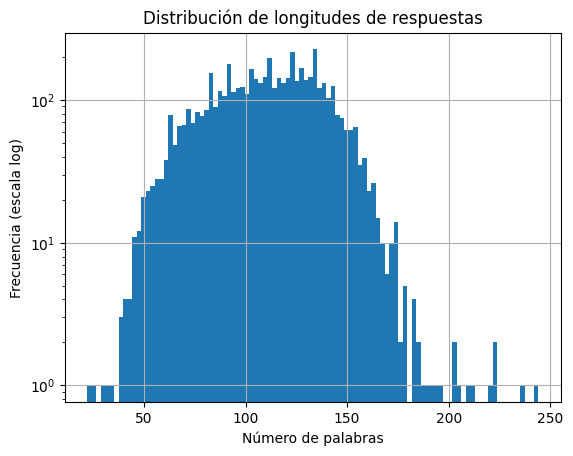

In [26]:
import matplotlib.pyplot as plt

longitudes = ds_final["train"]["num_words"]

plt.hist(longitudes, bins=100)
plt.yscale("log")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia (escala log)")
plt.title("Distribución de longitudes de respuestas")
plt.grid(True)
plt.show()